In [1]:
import pandas as pd
import os
import numpy as np
from re import match as match_regex
from shutil import move

In [2]:
print(os.getcwd())

/home/leon/Documents/Studienarbeit/EvalFramework/notebooks


## Reorganise Folder Structure

In [4]:
gtsdb_root = "../data/datasets/gtsdb"
gtsdb_train = f"{gtsdb_root}/TrainIJCNN2013"
gtsdb_test = f"{gtsdb_root}/TestIJCNN2013"

In [9]:
#os.mkdir(f"{gtsdb_train}/images")
for image in os.listdir(f"{gtsdb_train}/TrainIJCNN2013"):
    if match_regex(".*([.]ppm)", image):
        move(f"{gtsdb_train}/TrainIJCNN2013/{image}", f"{gtsdb_train}/images")

## Convert gt.txt of GTSDB to YOLO Format
YOLO format, with one *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:
- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).
![](https://user-images.githubusercontent.com/26833433/91506361-c7965000-e886-11ea-8291-c72b98c25eec.jpg)
The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):
![](https://user-images.githubusercontent.com/26833433/112467037-d2568c00-8d66-11eb-8796-55402ac0d62f.png)


- Filename: Filename of the image the annotations apply for
- Traffic sign's region of interest (ROI) in the image
    - leftmost image column of the ROI
    - upmost image row of the ROI
    - rightmost image column of the ROI
    - downmost image row of the ROI
- ID providing the traffic sign's class


In [2]:
df = pd.read_csv("../data/datasets/gtsdb/TrainIJCNN2013/TrainIJCNN2013/gt.txt",
                 sep=";",
                 names=["Filename", "X1.ROI", "Y1.ROI", "X2.ROI", "Y2.ROI", "classID"]
                 )
print(df)

      Filename  X1.ROI  Y1.ROI  X2.ROI  Y2.ROI  classID
0    00000.ppm     774     411     815     446       11
1    00001.ppm     983     388    1024     432       40
2    00001.ppm     386     494     442     552       38
3    00001.ppm     973     335    1031     390       13
4    00002.ppm     892     476    1006     592       39
..         ...     ...     ...     ...     ...      ...
847  00570.ppm     881     416     914     449        9
848  00571.ppm    1287     361    1308     384       17
849  00575.ppm     403     474     435     506       38
850  00593.ppm     584     510     608     534       38
851  00599.ppm     700     454     722     476        9

[852 rows x 6 columns]


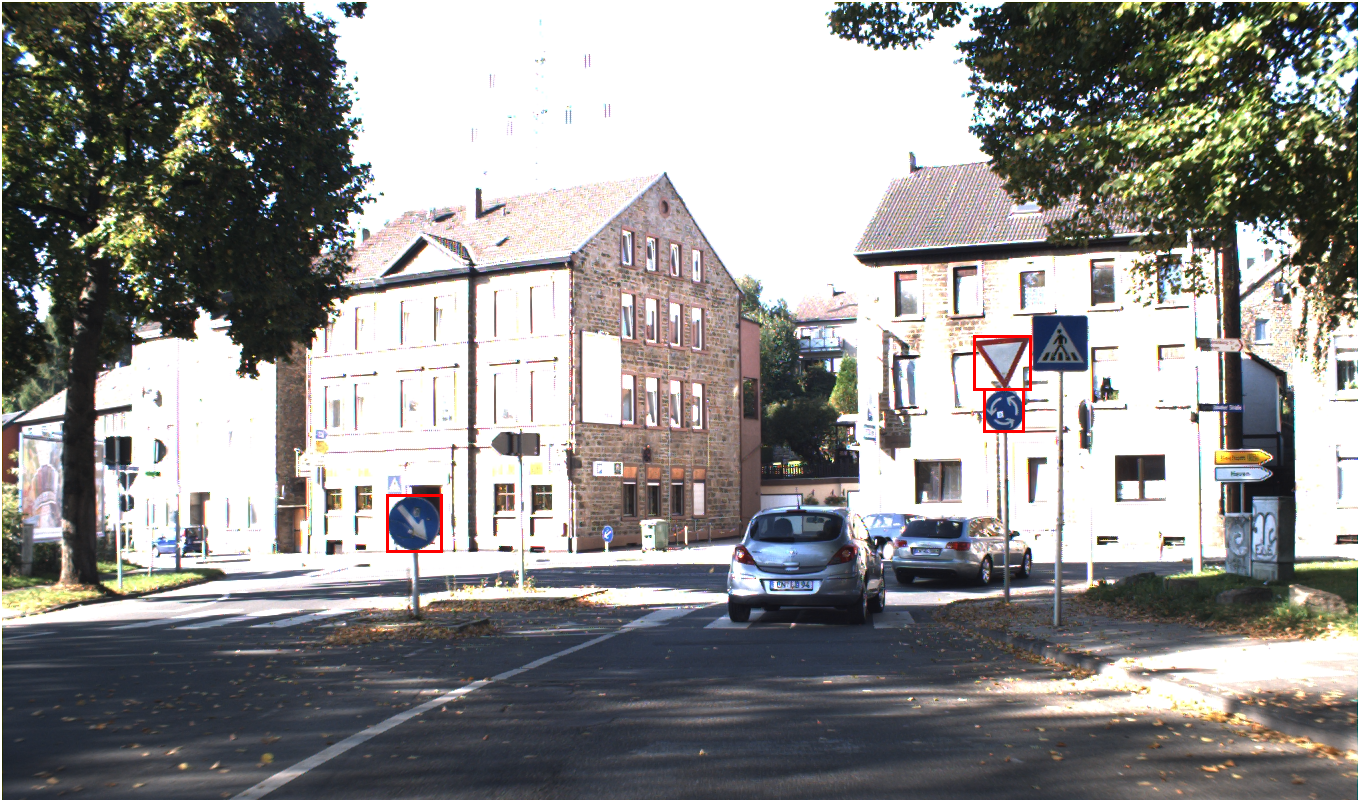

In [8]:
from PIL import Image, ImageDraw

with Image.open(f"{gtsdb_train}/TrainIJCNN2013/00001.ppm") as im:
    draw = ImageDraw.Draw(im)
    
    im_df = df.loc[df["Filename"] == "00001.ppm"].copy()

    for index, row in im_df.iterrows():

        x1 = row["X1.ROI"]
        y1 = row["Y1.ROI"]

        x2 = row["X2.ROI"]
        y2 = row["Y2.ROI"]

        draw.rectangle((x1,y1,x2,y2), outline="red" , width=3)
    im.save("gtsdb_exp.pdf")
    display(im)

In [4]:
image_size = (1360, 800) # (width, height)

In [4]:
# The center of rectangle is the midpoint of the diagonal end points of rectangle
test_row = df.loc[0]
x_center = (test_row.loc["X1.ROI"] + test_row.loc["X2.ROI"]) // 2
y_center = (test_row.loc["Y1.ROI"] + test_row.loc["Y2.ROI"]) // 2
box_width = test_row.loc["X2.ROI"] - test_row.loc["X1.ROI"]
box_height = test_row.loc["Y2.ROI"] - test_row.loc["Y1.ROI"]
print(x_center, y_center, box_height, box_width)

794 428 35 41


In [5]:
# Normalize Coordinates
df["X1.ROI"] /= image_size[0]
df["X2.ROI"] /= image_size[0]
df["Y1.ROI"] /= image_size[1]
df["Y2.ROI"] /= image_size[1]
print(df)

      Filename    X1.ROI   Y1.ROI    X2.ROI   Y2.ROI  classID
0    00000.ppm  0.569118  0.51375  0.599265  0.55750       11
1    00001.ppm  0.722794  0.48500  0.752941  0.54000       40
2    00001.ppm  0.283824  0.61750  0.325000  0.69000       38
3    00001.ppm  0.715441  0.41875  0.758088  0.48750       13
4    00002.ppm  0.655882  0.59500  0.739706  0.74000       39
..         ...       ...      ...       ...      ...      ...
847  00570.ppm  0.647794  0.52000  0.672059  0.56125        9
848  00571.ppm  0.946324  0.45125  0.961765  0.48000       17
849  00575.ppm  0.296324  0.59250  0.319853  0.63250       38
850  00593.ppm  0.429412  0.63750  0.447059  0.66750       38
851  00599.ppm  0.514706  0.56750  0.530882  0.59500        9

[852 rows x 6 columns]


In [6]:
print(df.loc[df["Filename"] == "00000.ppm"])

    Filename    X1.ROI   Y1.ROI    X2.ROI  Y2.ROI  classID
0  00000.ppm  0.569118  0.51375  0.599265  0.5575       11


In [6]:
for index, row in df.iterrows():
    print(row.loc['classID'])
    print([row.loc['classID'],
        (row.loc["X1.ROI"] + row.loc["X2.ROI"]) / 2.0,
        (row.loc["Y1.ROI"] + row.loc["Y2.ROI"]) / 2.0,
        row.loc["X2.ROI"] - row.loc["X1.ROI"],
        row.loc["Y2.ROI"] - row.loc["Y1.ROI"]])
    break

11
[11, 0.5841911764705883, 0.535625, 0.030147058823529416, 0.043749999999999956]


In [18]:
gt_converted = np.array([
    [
        row.loc['classID'],
        (row.loc["X1.ROI"] + row.loc["X2.ROI"]) / 2.0,
        (row.loc["Y1.ROI"] + row.loc["Y2.ROI"]) / 2.0,
        row.loc["X2.ROI"] - row.loc["X1.ROI"],
        row.loc["Y2.ROI"] - row.loc["Y1.ROI"]
    ] for index, row in df.iterrows()])
print(gt_converted.shape)
print(gt_converted)
print(df.loc[0].loc['classID'])

(852, 5)
[[1.10000000e+01 5.84191176e-01 5.35625000e-01 3.01470588e-02
  4.37500000e-02]
 [4.00000000e+01 7.37867647e-01 5.12500000e-01 3.01470588e-02
  5.50000000e-02]
 [3.80000000e+01 3.04411765e-01 6.53750000e-01 4.11764706e-02
  7.25000000e-02]
 ...
 [3.80000000e+01 3.08088235e-01 6.12500000e-01 2.35294118e-02
  4.00000000e-02]
 [3.80000000e+01 4.38235294e-01 6.52500000e-01 1.76470588e-02
  3.00000000e-02]
 [9.00000000e+00 5.22794118e-01 5.81250000e-01 1.61764706e-02
  2.75000000e-02]]
11


In [8]:
# check for invalid mappings
for index, row in df.iterrows():
    if row.loc["classID"] == gt_converted[index][0] and (row.loc["X1.ROI"] + row.loc["X2.ROI"]) / 2 == gt_converted[index][1] and (row.loc["Y1.ROI"] + row.loc["Y2.ROI"]) / 2 == gt_converted[index][2] and row.loc["X2.ROI"] - row.loc["X1.ROI"] == gt_converted[index][3] and row.loc["Y2.ROI"] - row.loc["Y1.ROI"] == gt_converted[index][4]:
        continue
    else:
        print("row false values")
    break

In [25]:
os.mkdir(f"{gtsdb_train}/labels")

In [11]:
with open(f"{gtsdb_train}/labels/{df.loc[0].loc['Filename'][:-4]}.txt", "w+") as f:
    print(f"{int(gt_converted[0][0])} {' '.join(map(str, gt_converted[0][1:]))}")
    f.write(f"{int(gt_converted[0][0])} {' '.join(map(str, gt_converted[0][1:]))}")
    f.close()

11 0.5841911764705883 0.535625 0.030147058823529416 0.043749999999999956


In [17]:
f = open(f"{gtsdb_train}/labels/00002.txt", "r")
in_annot = f.readlines()

['39 0.6977941176470588 0.6675 0.08382352941176474 0.14500000000000002']

In [21]:
x1 = (gt_converted[4][1] - gt_converted[4][3] / 2) * image_size[0]
print(x1)

891.9999999999999


## Check if annotations are converted correctly

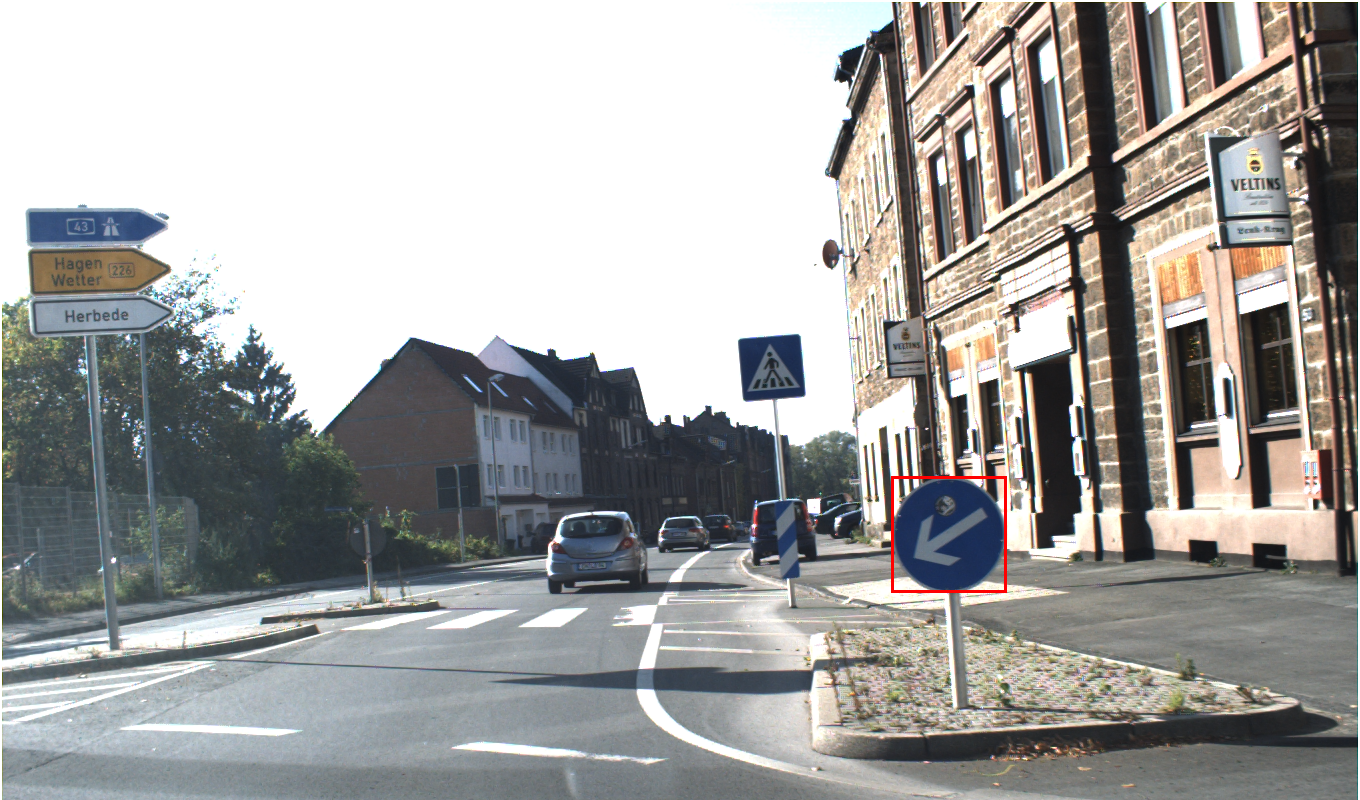

In [26]:
from PIL import Image, ImageDraw

with Image.open(f"{gtsdb_train}/images/00002.ppm") as im:
    draw = ImageDraw.Draw(im)

    # x1 = df.loc[4].loc['X1.ROI'] * image_size[0]
    # y1 = df.loc[4].loc['Y1.ROI'] * image_size[1]
    #
    # x2 = df.loc[4].loc['X2.ROI'] * image_size[0]
    # y2 = df.loc[4].loc['Y2.ROI'] * image_size[1]
    x1 = (gt_converted[4][1] - gt_converted[4][3] / 2) * image_size[0]
    y1 = (gt_converted[4][2] - gt_converted[4][4] / 2) * image_size[1]

    x2 = (gt_converted[4][1] + gt_converted[4][3] / 2) * image_size[0]
    y2 = (gt_converted[4][2] + gt_converted[4][4] / 2) * image_size[1]

    draw.rectangle((x1,y1,x2,y2), outline="red" , width=3)
    display(im)

## The gtsdb doesn't include annotations for the test set, therefore the data of the train split will be used to generate a new train, test, and validation split

In [6]:
print(df)

      Filename    X1.ROI   Y1.ROI    X2.ROI   Y2.ROI  classID
0    00000.ppm  0.569118  0.51375  0.599265  0.55750       11
1    00001.ppm  0.722794  0.48500  0.752941  0.54000       40
2    00001.ppm  0.283824  0.61750  0.325000  0.69000       38
3    00001.ppm  0.715441  0.41875  0.758088  0.48750       13
4    00002.ppm  0.655882  0.59500  0.739706  0.74000       39
..         ...       ...      ...       ...      ...      ...
847  00570.ppm  0.647794  0.52000  0.672059  0.56125        9
848  00571.ppm  0.946324  0.45125  0.961765  0.48000       17
849  00575.ppm  0.296324  0.59250  0.319853  0.63250       38
850  00593.ppm  0.429412  0.63750  0.447059  0.66750       38
851  00599.ppm  0.514706  0.56750  0.530882  0.59500        9

[852 rows x 6 columns]


In [7]:
train, val, test = np.split(df.sample(frac=1,random_state=42), [int(.6*len(df)), int(.8*len(df))])
print(f"train: \n {train}")
print(f"val: \n {val}")
print(f"test: \n {test}")

train: 
       Filename    X1.ROI   Y1.ROI    X2.ROI   Y2.ROI  classID
66   00044.ppm  0.552941  0.50375  0.575000  0.54125       12
434  00274.ppm  0.716912  0.49375  0.743382  0.53750        0
198  00123.ppm  0.381618  0.61500  0.404412  0.65500        7
212  00130.ppm  0.233824  0.54875  0.253676  0.58375       18
651  00406.ppm  0.769118  0.62875  0.806618  0.68875       30
..         ...       ...      ...       ...      ...      ...
169  00103.ppm  0.622794  0.43625  0.659559  0.49625       12
538  00344.ppm  0.587500  0.51625  0.646324  0.61750       12
38   00026.ppm  0.333088  0.51375  0.361765  0.56375        1
175  00107.ppm  0.357353  0.60625  0.397059  0.67125       25
245  00157.ppm  0.192647  0.52875  0.218382  0.57500        9

[511 rows x 6 columns]
val: 
       Filename    X1.ROI   Y1.ROI    X2.ROI   Y2.ROI  classID
298  00190.ppm  0.492647  0.50000  0.506618  0.52625       35
709  00447.ppm  0.869118  0.52250  0.932353  0.61875       13
580  00370.ppm  0.647059  0.69

In [13]:
from pathlib import Path
def create_folders(*paths):
    for path in paths:
        print(path)

create_folders(f"{gtsdb_root}/train/images", f"{gtsdb_root}/train/labels")
# p = Path(f"{gtsdb_root}/train/images")
# p.mkdir(parents=True, exist_ok=True)
#
# p = Path(f"{gtsdb_root}/train/labels")
# p.mkdir(parents=True, exist_ok=True)

../data/datasets/gtsdb/train/images
../data/datasets/gtsdb/train/labels


In [22]:
filenames = [image for image in os.listdir(f"{gtsdb_train}/TrainIJCNN2013") if match_regex(".*([.]ppm)", image)]
print(len(filenames))
filenames = pd.DataFrame(filenames)
train, val, test = np.split(filenames.sample(frac=1,random_state=42), [int(.6*len(filenames)), int(.8*len(filenames))])
print(f"train: \n {train}")
print(f"val: \n {val}")
print(f"test: \n {test}")
print(f"lengths: {len(train) + len(test) + len(val)}")

600
train: 
              0
110  00207.ppm
419  00405.ppm
565  00367.ppm
77   00579.ppm
181  00078.ppm
..         ...
147  00089.ppm
420  00350.ppm
348  00007.ppm
325  00552.ppm
513  00221.ppm

[360 rows x 1 columns]
val: 
              0
123  00323.ppm
502  00191.ppm
96   00275.ppm
143  00193.ppm
239  00465.ppm
..         ...
358  00125.ppm
397  00385.ppm
254  00376.ppm
217  00219.ppm
4    00372.ppm

[120 rows x 1 columns]
test: 
              0
256  00543.ppm
563  00523.ppm
533  00580.ppm
430  00444.ppm
100  00271.ppm
..         ...
71   00020.ppm
106  00431.ppm
270  00451.ppm
435  00058.ppm
102  00464.ppm

[120 rows x 1 columns]
lengths: 600


In [32]:
print(train[0])
for name in train[0]:
    print(name)

110    00207.ppm
419    00405.ppm
565    00367.ppm
77     00579.ppm
181    00078.ppm
         ...    
147    00089.ppm
420    00350.ppm
348    00007.ppm
325    00552.ppm
513    00221.ppm
Name: 0, Length: 360, dtype: object
00207.ppm
00405.ppm
00367.ppm
00579.ppm
00078.ppm
00064.ppm
00165.ppm
00319.ppm
00410.ppm
00031.ppm
00577.ppm
00137.ppm
00532.ppm
00145.ppm
00200.ppm
00473.ppm
00440.ppm
00057.ppm
00325.ppm
00491.ppm
00101.ppm
00558.ppm
00547.ppm
00408.ppm
00231.ppm
00039.ppm
00277.ppm
00123.ppm
00432.ppm
00269.ppm
00422.ppm
00592.ppm
00108.ppm
00551.ppm
00340.ppm
00035.ppm
00128.ppm
00479.ppm
00456.ppm
00087.ppm
00224.ppm
00457.ppm
00333.ppm
00447.ppm
00032.ppm
00139.ppm
00520.ppm
00150.ppm
00144.ppm
00589.ppm
00177.ppm
00521.ppm
00095.ppm
00416.ppm
00208.ppm
00346.ppm
00324.ppm
00443.ppm
00293.ppm
00056.ppm
00105.ppm
00194.ppm
00573.ppm
00511.ppm
00236.ppm
00349.ppm
00213.ppm
00253.ppm
00112.ppm
00570.ppm
00399.ppm
00477.ppm
00493.ppm
00448.ppm
00555.ppm
00384.ppm
00594.ppm
00281.p